<a href="https://colab.research.google.com/github/dudco0040/dudco0040/blob/master/%EB%84%A4%EC%9D%B4%EB%B2%84%20%EC%87%BC%ED%95%91%20%EB%A6%AC%EB%B7%B0%20%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EA%B2%B0%EA%B3%BC%20%ED%8F%AC%ED%95%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt",
filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 595 kB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 448 kB 52.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-16 09:52:52--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.

In [5]:
#label(긍정,중립,부정) 분리하기
#1:부정, 2~4:중립, 5:긍정
total_data['label'] = np.select([(total_data.ratings==5),(total_data.ratings==4),(total_data.ratings==2),(total_data.ratings==1)], [1,0,0,-1])  # -1:부정, 0:중립, 1:긍정
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [6]:
len(total_data)

200000

In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 3)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [9]:
print(total_data.isnull().values.any())

False


훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


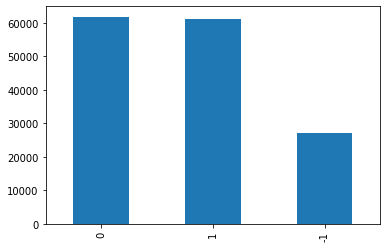

In [10]:
#train/test data 나누기
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
train_data['ratings'].value_counts()

5    61022
2    47827
1    27091
4    13991
Name: ratings, dtype: int64

In [12]:
train_data['label'].value_counts()

 0    61818
 1    61022
-1    27091
Name: label, dtype: int64

In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

ratings    0
reviews    0
label      0
dtype: int64
전처리 후 테스트용 샘플의 개수 : 49977


In [14]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

#불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

#단어와 길이 분포 확인하기
negative_words = np.hstack(train_data[train_data.label == -1]['tokenized'].values)
neutrality_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_word_count = Counter(negative_words)
neutrality_words_count = Counter(neutrality_words)
positive_words_count = Counter(positive_words)

#빈도수가 높은 상위 20개 단어만 출력
print("부정 리뷰")
print(negative_word_count.most_common(20))
print("중립 리뷰")
print(neutrality_words_count.most_common(20))
print("긍정 리뷰")
print(positive_words_count.most_common(20))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']
부정 리뷰
[('네요', 11653), ('안', 8369), ('는데', 8012), ('어요', 5544), ('너무', 4811), ('있', 4619), ('했', 4448), ('구매', 3838), ('없', 3682), ('배송', 3426), ('거', 3425), ('되', 3392), ('어', 3376), ('습니다', 3219), ('그냥', 3064), ('좋', 3001), ('같', 2981), ('나', 2907), ('만', 2820), ('요', 2751)]
중립 리뷰
[('네요', 24530), ('는데', 14610), ('좋', 13989), ('어요', 12879), ('안', 12440), ('있', 11349), ('아요', 10472), ('했', 9233), ('너무', 9162), ('잘', 9013), ('배송', 8426), ('같', 8136), ('습니다', 7690), ('구매', 7448), ('거', 6998), ('어', 6850), ('않', 6429), ('되', 6037), ('없', 5738), ('요', 5729)]
긍정 리뷰
[('좋', 32310), ('아요', 16800), ('네요', 15511), ('잘', 15164), ('어요', 15112), ('구매', 13761), ('습니다', 10847), ('배송', 10100), ('있', 9623), ('는데', 9343), ('합니다', 8186), ('재', 7975), ('먹', 7954), ('했', 7920), ('너무', 7482), ('만족', 6042), ('같', 5748), ('쓰', 5075), ('아', 4944), ('어', 4937)]


긍정 리뷰의 평균 길이 : 13.3221788863033
중립 리뷰의 평균 길이 : 16.175240221294768
부정 리뷰의 평균 길이 : 17.79945369310841


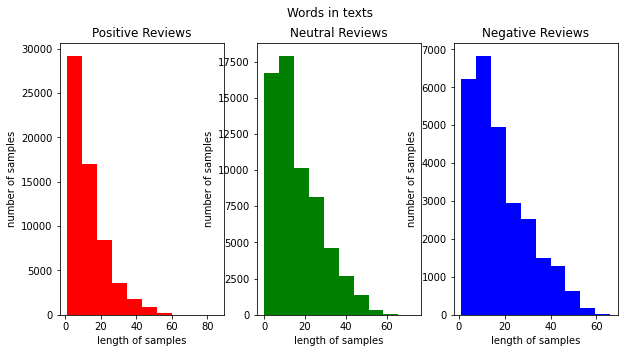

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))

text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color = 'green')
ax2.set_title('Neutral Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('중립 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==-1]['tokenized'].map(lambda x: len(x))
ax3.hist(text_len, color='blue')
ax3.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax3.set_xlabel('length of samples')
ax3.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [16]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [17]:
#정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value
  # 단어의 등장 빈도수가 threshold보다 작으면
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value
    
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935698749320282


In [19]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])
print(X_test[:3])

단어 집합의 크기 : 21787
[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]
[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


In [20]:
#one-hot encoding

import numpy as np 
y_train_onehot = [] 
y_test_onehot = [] 
for i in range(len(y_train)): 
  if y_train[i] == 1: 
    y_train_onehot.append([0, 0, 1]) 
  elif y_train[i] == 0: 
    y_train_onehot.append([0, 1, 0]) 
  elif y_train[i] == -1: 
    y_train_onehot.append([1, 0, 0]) 
    
  
for i in range(len(y_test)): 
  if y_test[i] == 1:
    y_test_onehot.append([0, 0, 1])
  elif y_test[i] == 0: 
    y_test_onehot.append([0, 1, 0]) 
  elif y_test[i] == -1: 
    y_test_onehot.append([1, 0, 0]) 

y_train_onehot = np.array(y_train_onehot) 
y_test_onehot = np.array(y_test_onehot)


In [18]:
y_train_onehot

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [19]:
y_train

array([ 0,  0, -1, ...,  0,  1,  0])

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307521459871541


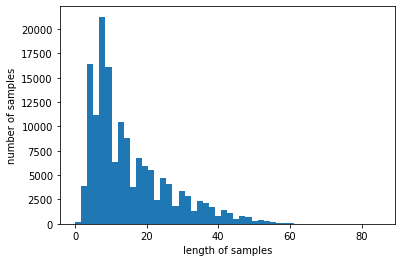

In [20]:
#패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
  
max_len = 80
below_threshold_len(max_len, X_train)
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [22]:
X_train #패딩이 완료된 input data

array([[  0,   0,   0, ..., 155,   3,   6],
       [  0,   0,   0, ...,  38, 473,   2],
       [  0,   0,   0, ..., 323, 119, 136],
       ...,
       [  0,   0,   0, ..., 438, 477,  50],
       [  0,   0,   0, ...,  52,  19, 185],
       [  0,   0,   0, ...,   7, 503,   4]], dtype=int32)

**GRU**
rmsprop epoch=15

In [24]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#verbose=1 로 지정하면, 언제 keras 에서 training 을 멈추었는지를 화면에 출력
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.7084 - acc: 0.6756
Epoch 00001: val_acc improved from -inf to 0.69120, saving model to best_model.h5
1875/1875 [==============================] - 49s 25ms/step - loss: 0.7084 - acc: 0.6756 - val_loss: 0.6686 - val_acc: 0.6912
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.6429 - acc: 0.7103
Epoch 00002: val_acc improved from 0.69120 to 0.70334, saving model to best_model.h5
1875/1875 [==============================] - 44s 24ms/step - loss: 0.6429 - acc: 0.7103 - val_loss: 0.6527 - val_acc: 0.7033
Epoch 3/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.6167 - acc: 0.7264
Epoch 00003: val_acc did not improve from 0.70334
1875/1875 [==============================] - 47s 25ms/step - loss: 0.6167 - acc: 0.7264 - val_loss: 0.6599 - val_acc: 0.7005
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.5953 - acc: 0.7370
Epoch 00004: val_acc improved from 0

In [25]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 14s 9ms/step - loss: 0.6822 - acc: 0.6903

 테스트 정확도: 69.03%


epoch = 3으로 변경

In [29]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=3, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/3
1874/1875 [============================>.] - ETA: 0s - loss: 0.7081 - acc: 0.6751
Epoch 00001: val_acc improved from -inf to 0.69180, saving model to best_model.h5
1875/1875 [==============================] - 49s 25ms/step - loss: 0.7081 - acc: 0.6752 - val_loss: 0.6728 - val_acc: 0.6918
Epoch 2/3
1874/1875 [============================>.] - ETA: 0s - loss: 0.6439 - acc: 0.7100
Epoch 00002: val_acc improved from 0.69180 to 0.70010, saving model to best_model.h5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.6439 - acc: 0.7100 - val_loss: 0.6595 - val_acc: 0.7001
Epoch 3/3
1875/1875 [==============================] - ETA: 0s - loss: 0.6170 - acc: 0.7255
Epoch 00003: val_acc improved from 0.70010 to 0.70401, saving model to best_model.h5
1875/1875 [==============================] - 47s 25ms/step - loss: 0.6170 - acc: 0.7255 - val_loss: 0.6598 - val_acc: 0.7040


In [27]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 14s 9ms/step - loss: 0.6614 - acc: 0.6981

 테스트 정확도: 69.81%


**GRU**
adam epoch=15

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.7021 - acc: 0.6765
Epoch 00001: val_acc improved from -inf to 0.69894, saving model to best_model.h5
1875/1875 [==============================] - 322s 170ms/step - loss: 0.7021 - acc: 0.6765 - val_loss: 0.6626 - val_acc: 0.6989
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.6146 - acc: 0.7247
Epoch 00002: val_acc improved from 0.69894 to 0.70070, saving model to best_model.h5
1875/1875 [==============================] - 319s 170ms/step - loss: 0.6146 - acc: 0.7247 - val_loss: 0.6560 - val_acc: 0.7007
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.5622 - acc: 0.7537
Epoch 00003: val_acc did not improve from 0.70070
1875/1875 [==============================] - 319s 170ms/step - loss: 0.5622 - acc: 0.7537 - val_loss: 0.6759 - val_acc: 0.6946
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.5079 - acc: 0.7806
Epoch 00004: val_acc did not i

In [ ]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 33s 21ms/step - loss: 0.9607 - acc: 0.6591

 테스트 정확도: 65.91%


epoch =4 로 변경

In [26]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=2, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/2
1873/1875 [============================>.] - ETA: 0s - loss: 0.6996 - acc: 0.6795
Epoch 00001: val_acc improved from -inf to 0.69810, saving model to best_model.h5
1875/1875 [==============================] - 45s 23ms/step - loss: 0.6996 - acc: 0.6795 - val_loss: 0.6589 - val_acc: 0.6981
Epoch 2/2
1874/1875 [============================>.] - ETA: 0s - loss: 0.6143 - acc: 0.7247
Epoch 00002: val_acc improved from 0.69810 to 0.70097, saving model to best_model.h5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.6143 - acc: 0.7247 - val_loss: 0.6559 - val_acc: 0.7010


In [27]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 15s 9ms/step - loss: 0.6589 - acc: 0.7000

 테스트 정확도: 70.00%


**GRU**
rsmprop

drop out


In [26]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.7182 - acc: 0.6719
Epoch 00001: val_acc improved from -inf to 0.69310, saving model to best_model.h5
1875/1875 [==============================] - 57s 27ms/step - loss: 0.7182 - acc: 0.6719 - val_loss: 0.6785 - val_acc: 0.6931
Epoch 2/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.6530 - acc: 0.7076
Epoch 00002: val_acc improved from 0.69310 to 0.70064, saving model to best_model.h5
1875/1875 [==============================] - 48s 25ms/step - loss: 0.6530 - acc: 0.7076 - val_loss: 0.6571 - val_acc: 0.7006
Epoch 3/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.6290 - acc: 0.7215
Epoch 00003: val_acc improved from 0.70064 to 0.70491, saving model to best_model.h5
1875/1875 [==============================] - 46s 25ms/step - loss: 0.6290 - acc: 0.7215 - val_loss: 0.6558 - val_acc: 0.7049
Epoch 4/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.6098 - acc: 0.7329
E

In [27]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 15s 9ms/step - loss: 0.7068 - acc: 0.6940

 테스트 정확도: 69.40%


In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [ ]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

**LSTM**
adam

In [ ]:
#LSTM 사용
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.7081 - acc: 0.6748
Epoch 00001: val_acc improved from -inf to 0.69694, saving model to best_model.h5
1875/1875 [==============================] - 408s 216ms/step - loss: 0.7081 - acc: 0.6748 - val_loss: 0.6673 - val_acc: 0.6969
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.6217 - acc: 0.7205
Epoch 00002: val_acc improved from 0.69694 to 0.69914, saving model to best_model.h5
1875/1875 [==============================] - 404s 215ms/step - loss: 0.6217 - acc: 0.7205 - val_loss: 0.6596 - val_acc: 0.6991
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.5729 - acc: 0.7473
Epoch 00003: val_acc improved from 0.69914 to 0.69940, saving model to best_model.h5
1875/1875 [==============================] - 401s 214ms/step - loss: 0.5729 - acc: 0.7473 - val_loss: 0.6692 - val_acc: 0.6994
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.5217 - acc: 0.

In [ ]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 14s 9ms/step - loss: 0.9367 - acc: 0.6691

 테스트 정확도: 66.91%


**LSTM**
rmsprop

In [ ]:
#LSTM 사용
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.7105 - acc: 0.6739
Epoch 00001: val_acc improved from -inf to 0.68803, saving model to best_model.h5
1875/1875 [==============================] - 45s 23ms/step - loss: 0.7105 - acc: 0.6739 - val_loss: 0.6863 - val_acc: 0.6880
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.6459 - acc: 0.7094
Epoch 00002: val_acc improved from 0.68803 to 0.69977, saving model to best_model.h5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.6459 - acc: 0.7094 - val_loss: 0.6630 - val_acc: 0.6998
Epoch 3/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.6200 - acc: 0.7236
Epoch 00003: val_acc improved from 0.69977 to 0.70344, saving model to best_model.h5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.6200 - acc: 0.7236 - val_loss: 0.6751 - val_acc: 0.7034
Epoch 4/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.6001 - acc: 0.7363
E

In [32]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 15s 9ms/step - loss: 0.6515 - acc: 0.7061

 테스트 정확도: 70.61%


epoch = 4로 변경

In [25]:
#LSTM 사용
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=4, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/4
1873/1875 [============================>.] - ETA: 0s - loss: 0.7107 - acc: 0.6741
Epoch 00001: val_acc improved from -inf to 0.69283, saving model to best_model.h5
1875/1875 [==============================] - 46s 23ms/step - loss: 0.7106 - acc: 0.6741 - val_loss: 0.6802 - val_acc: 0.6928
Epoch 2/4
1875/1875 [==============================] - ETA: 0s - loss: 0.6462 - acc: 0.7083
Epoch 00002: val_acc improved from 0.69283 to 0.69850, saving model to best_model.h5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.6462 - acc: 0.7083 - val_loss: 0.6572 - val_acc: 0.6985
Epoch 3/4
1874/1875 [============================>.] - ETA: 0s - loss: 0.6204 - acc: 0.7242
Epoch 00003: val_acc improved from 0.69850 to 0.70100, saving model to best_model.h5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.6203 - acc: 0.7242 - val_loss: 0.6550 - val_acc: 0.7010
Epoch 4/4
1874/1875 [============================>.] - ETA: 0s - loss: 0.6000 - acc: 0.7359
Epoch

In [26]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 14s 9ms/step - loss: 0.6665 - acc: 0.7042

 테스트 정확도: 70.42%


**LSTM**
rmsprop 

dropout 50%

In [28]:
#LSTM 사용
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.7199 - acc: 0.6702
Epoch 00001: val_acc improved from -inf to 0.69007, saving model to best_model.h5
1875/1875 [==============================] - 48s 24ms/step - loss: 0.7199 - acc: 0.6702 - val_loss: 0.6742 - val_acc: 0.6901
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.6578 - acc: 0.7059
Epoch 00002: val_acc improved from 0.69007 to 0.70140, saving model to best_model.h5
1875/1875 [==============================] - 44s 24ms/step - loss: 0.6578 - acc: 0.7059 - val_loss: 0.6621 - val_acc: 0.7014
Epoch 3/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.6332 - acc: 0.7186
Epoch 00003: val_acc improved from 0.70140 to 0.70594, saving model to best_model.h5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.6333 - acc: 0.7185 - val_loss: 0.6490 - val_acc: 0.7059
Epoch 4/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.6146 - acc: 0.7300
E

In [29]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 15s 10ms/step - loss: 0.6924 - acc: 0.6947

 테스트 정확도: 69.47%


In [23]:
#LSTM 사용
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 50
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.7223 - acc: 0.6686
Epoch 00001: val_acc improved from -inf to 0.68500, saving model to best_model.h5
1875/1875 [==============================] - 60s 29ms/step - loss: 0.7223 - acc: 0.6686 - val_loss: 0.6940 - val_acc: 0.6850
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.6531 - acc: 0.7046
Epoch 00002: val_acc improved from 0.68500 to 0.70104, saving model to best_model.h5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.6531 - acc: 0.7046 - val_loss: 0.6572 - val_acc: 0.7010
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.6286 - acc: 0.7191
Epoch 00003: val_acc improved from 0.70104 to 0.70471, saving model to best_model.h5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.6286 - acc: 0.7191 - val_loss: 0.6527 - val_acc: 0.7047
Epoch 4/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.6111 - acc: 0.7288
E

In [24]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 20s 13ms/step - loss: 0.6923 - acc: 0.6904

 테스트 정확도: 69.04%


**bi LSRM** 
rmsprop

In [32]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
468/469 [============================>.] - ETA: 0s - loss: 0.7320 - acc: 0.6646
Epoch 00001: val_acc improved from -inf to 0.69183, saving model to best_model.h5
469/469 [==============================] - 33s 61ms/step - loss: 0.7318 - acc: 0.6647 - val_loss: 0.6773 - val_acc: 0.6918
Epoch 2/15
468/469 [============================>.] - ETA: 0s - loss: 0.6539 - acc: 0.7039
Epoch 00002: val_acc improved from 0.69183 to 0.69580, saving model to best_model.h5
469/469 [==============================] - 28s 59ms/step - loss: 0.6540 - acc: 0.7038 - val_loss: 0.6659 - val_acc: 0.6958
Epoch 3/15
468/469 [============================>.] - ETA: 0s - loss: 0.6267 - acc: 0.7210
Epoch 00003: val_acc improved from 0.69580 to 0.70180, saving model to best_model.h5
469/469 [==============================] - 27s 59ms/step - loss: 0.6267 - acc: 0.7210 - val_loss: 0.6579 - val_acc: 0.7018
Epoch 4/15
468/469 [============================>.] - ETA: 0s - loss: 0.6043 - acc: 0.7334
Epoch 00004: va

In [30]:
print("\n 테스트 정확도: {:.2f}%".format(model.evaluate(X_test,y_test_onehot)[1]*100))

1562/1562 [==============================] - 25s 16ms/step - loss: 0.7092 - acc: 0.6870

 테스트 정확도: 68.70%


In [31]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))

model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_onehot, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

ValueError: ignored

In [39]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 3.3 MB 39.2 MB/s 
     |████████████████████████████████| 61 kB 473 kB/s 
     |████████████████████████████████| 895 kB 44.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [40]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [41]:
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla K80


총 샘플의 수 : 199908
False
훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977
   label  count
0     -1  27091
1      0  61818
2      1  61022
ratings    0
reviews    0
label      0
dtype: int64
전처리 후 테스트용 샘플의 개수 : 49977


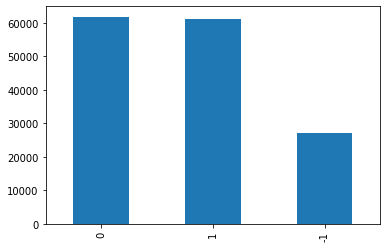

In [49]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))
print(total_data.isnull().values.any())
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))



In [51]:
train_data

,ratings,reviews,label
59666,2,사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...,0
12433,2,ㅂ불만족 빗이 아픔 멍이피부에 빗질못해주겟네요,0
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...,-1
158109,5,적당하고 만족합니다,1
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0
...,...,...,...
119904,2,그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ 그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ ㅁㅁㅁㅁ ㅋㅋㅋㅋ ㅌㅌㅌㅌ...,0
103714,2,비싸요 진짜 별거 아니게 허접하게 생겼는데 이게 이만원이라니 진짜 가방 구겨지는것만...,0
131960,2,장 주문 안됩니다 장 가능해요,0
146908,5,하림치킨 여기서 구입하니 엄청 저렴하네요 배송도 쾅꽝 얼어서 도착하고 아주 만족합...,1


In [52]:
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train_data['reviews']]
document_bert[:5]


['[CLS] 사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이 아쉽지만 암막효과는 좋아요 [SEP]',
 '[CLS] ㅂ불만족 빗이 아픔  멍이피부에 빗질못해주겟네요 [SEP]',
 '[CLS] 이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘 내려가네요 이 많은걸 다 어쩌나요 반품하고싶다 [SEP]',
 '[CLS] 적당하고 만족합니다 [SEP]',
 '[CLS] 편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요 [SEP]']

In [53]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(tokenized_texts[0])

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

['[CLS]', '사', '##이', '##즈', '##를', '센', '##치', '##씩', '늘', '##린', '##건', '##데', '##도', '작', '##아', '##요', '그리고', '색', '##상', '##은', '완', '##전', '달', '##라', '##요', '[UNK]', '많이', '아', '##쉽', '##지만', '암', '##막', '##효', '##과', '##는', '좋', '##아', '##요', '[SEP]']


In [54]:
MAX_LEN = 80
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9405,  10739,  24891,  11513,   9437,  18622, 119108,
         9044,  27654,  71439,  28911,  12092,   9652,  16985,  48549,
        23289,   9416,  14871,  10892,   9591,  16617,   9061,  17342,
        48549,    100,  47058,   9519, 119072,  28578,   9526, 118907,
       119449,  11882,  11018,   9685,  16985,  48549,    102,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0])

In [55]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [57]:
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, train_data['label'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.1)

In [58]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [59]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [62]:
sentences = test_data['reviews']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test_data['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [63]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [65]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [66]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [67]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [68]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...


RuntimeError: ignored

koBERT

In [2]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

     |████████████████████████████████| 46.9 MB 1.7 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595720 sha256=2400e8f6f50dcbebab10702dde52773bee56ada145c0dce83f5ed4493e5f5dc2
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 769 kB 5.4 MB/s 
     |████████████████████████████████| 3.0 MB 37.9 MB/s 
     |████████████████████████████████| 895 kB 37.0 MB/s 


In [3]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-p6sqwqle
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-p6sqwqle
     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 24.9 MB/s 
     |████████████████████████████████| 596 kB 35.2 MB/s 
     |████████████████████████████████| 61 kB 520 kB/s 
     |████████████████████████████████| 3.3 MB 12.0 MB/s 
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=13136 sha256=c24c90babbeb2dc3339e32fb2586d4cb7cd0b355837f39dc9a3933f7b91210df
  Stored in directory: /tmp/pip-ephem-wheel-cache-ia9xjcgj/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tokenizers
    Found existi

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
#GPU 사용
device = torch.device("cuda:0")
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

.cache/kobert_v1.zip[██████████████████████████████████████████████████]
.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [15]:
data_list = []
for q, label in zip(total_data['reviews'], total_data['label']):
    data = []
    data.append(q)
    data.append(str(label))
    
    data_list.append(data)

In [17]:
data_list[:5]  # total_data 리뷰 내용 리스트

[['배공빠르고 굿', '1'],
 ['택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고', '0'],
 ['아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.', '1'],
 ['선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..',
  '0'],
 ['민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ', '1']]

In [18]:
#train/test data split

from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=42)
#train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)


In [19]:
print(len(dataset_train))
print(len(dataset_test))

149931
49977


In [20]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [21]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [22]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [25]:
#확인
data_train[0]

(array([   2, 2618, 7310, 6116,  589, 6591, 7483, 6792, 1550, 6133, 5384,
        5850, 5859, 3930, 6797, 6999, 1210,  517, 6538, 6527, 7086, 3461,
        1598, 6999,  517, 7488, 7488, 7828, 7781, 5703,    0, 1956, 3093,
        6657, 7330, 3177, 6149, 7966, 5760, 4207, 6999,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(42, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [26]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
train_dataloader

In [28]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [29]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [30]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/2343 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요...저는 강추합니다. 대박’)
sentiment_predict('진짜 배송도 늦고 짜증나네요. 뭐 이런 걸 상품이라고...’)
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')